## Modeling for predicting critical outcome at ED triage

In [ ]:
# This notebook uses Logistic Regression, Gradient Boosting and MLP for ED triage - Critical Outcome

Work Flow:
1. Task-specific filter
2. Variable selection
3. Modeling script
4. Performance output


### Load train and test

In [1]:
import os
import time
import random
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from helpers import PlotROCCurve
# from dataset_path import output_path

# path = output_path
# output_path = os.path.join(path, "Figure3")

# df_train = pd.read_csv((os.path.join(path, 'train.csv')))
# df_test = pd.read_csv((os.path.join(path, 'test.csv')))
confidence_interval = 95
random_seed = 0

In [2]:
random.seed(random_seed)
np.random.seed(random_seed)

In [3]:
df_train = pd.read_csv(r'E:\SMU_Project_Healthcare\ISSS623_Healthcare_Analytics\Modeling\INPUT_DATA_New\train_drop_v3.csv')
df_test= pd.read_csv(r'E:\SMU_Project_Healthcare\ISSS623_Healthcare_Analytics\Modeling\INPUT_DATA_New\test_drop_v3.csv')

In [4]:
pd.set_option('display.max_columns', 100) 
pd.set_option('display.max_rows', 100) 

df_train.head()

,intime_ed,outtime_ed,gender,age,outcome_hospitalization,outcome_inhospital_mortality,ed_death,outcome_icu_transfer_12h,outcome_critical,n_ed_30d,n_ed_90d,n_ed_365d,outcome_ed_revisit_3d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,ed_los_hours,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,...,eci_PVD,eci_HTN1,eci_HTN2,eci_Paralysis,eci_NeuroOther,eci_Pulmonary,eci_DM1,eci_DM2,eci_Hypothyroid,eci_Renal,eci_Liver,eci_PUD,eci_HIV,eci_Lymphoma,eci_Tumor2,eci_Tumor1,eci_Rheumatic,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon,insurance_Medicaid,insurance_Medicare,insurance_Other,age_group_Young Adults,age_group_Middle-Aged Adults,age_group_Older Adults,age_group_Elderly,triage_MAP,score_CCI,score_CART,score_REMS,score_NEWS,score_NEWS2,score_MEWS
0,9/7/2179 12:19,9/7/2179 12:24,1,52,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.08,36.666667,78.0,18,99.0,123,87,6.0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.777778,56.0,16,98.0,105,66,2.0,0,0,0,0,0,0,1,0,0,99.000000,1,0,2,0,0,1
1,3/17/2138 10:35,3/17/2138 10:41,0,69,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.10,37.055556,65.0,18,100.0,149,60,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,...,1,0,0,0,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.722222,58.0,16,98.0,143,61,0.0,0,19,0,0,0,0,0,1,0,89.666667,8,4,7,0,0,1
2,10/23/2136 14:50,10/23/2136 14:59,1,30,0,0,0,0,0,0,0,3,0,0,0,2,0,0,0,0.15,37.000000,82.0,20,100.0,160,85,7.0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,36.888889,66.0,18,98.0,127,83,0.0,1,1,0,0,0,1,0,0,0,110.000000,1,0,2,0,0,1
3,8/1/2188 2:06,8/1/2188 9:57,1,39,1,0,0,0,0,0,0,3,1,0,0,1,0,0,0,7.85,36.111111,78.0,14,95.0,127,77,0.0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,36.333333,76.0,18,98.0,107,54,0.0,1,2,0,0,1,0,1,0,0,93.666667,1,0,0,1,0,0
4,11/12/2143 10:30,11/12/2143 20:41,1,59,1,0,0,0,0,0,2,3,0,0,4,4,0,0,0,10.19,36.888889,63.0,18,99.0,230,87,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,...,0,0,1,0,1,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,36.833333,60.0,16,97.0,164,65,0.0,5,13,0,0,1,0,1,0,0,134.666667,6,4,8,3,3,3


### 1. Task-specific filter: no task-specific exclusion needed

In [5]:
print('training size =', len(df_train), ', testing size =', len(df_test))

training size = 273032 , testing size = 68258


### 2. Variable Selection

In [6]:
variable = ["age", "gender", 
            
            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", 
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
            
            "triage_temperature", "triage_heartrate", "triage_resprate", 
            "triage_o2sat", "triage_sbp", "triage_dbp", "triage_pain", "triage_acuity",
            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache",
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope", 
            "chiefcom_dizziness", 
            
            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", 
            "cci_Pulmonary", "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", 
            "cci_DM2", "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", 
            "cci_Cancer2", "cci_HIV", 
            
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2", 
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss",
            "eci_Anemia", "eci_Alcohol", "eci_Drugs","eci_Psychoses", "eci_Depression"]

outcome = "outcome_critical"

In [7]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [8]:
X_train.dtypes.to_frame().T

,age,gender,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_HTN1,eci_HTN2,eci_NeuroOther,eci_Hypothyroid,eci_Lymphoma,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression
0,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int64,float64,int64,int64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64


In [9]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])

In [10]:
print('class ratio')
ratio = y_train.sum()/(~y_train).sum()
print('positive : negative =', ratio, ': 1')

class ratio
positive : negative = -0.04078470775468046 : 1


In [11]:
X_train.head()

,age,gender,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_HTN1,eci_HTN2,eci_NeuroOther,eci_Hypothyroid,eci_Lymphoma,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression
0,52,1,0,0,1,0,0,0,0,0,0,36.666667,78.0,18,99.0,123,87,6.0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,69,0,0,0,0,0,0,0,0,0,0,37.055556,65.0,18,100.0,149,60,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
2,30,1,0,0,3,0,0,2,0,0,0,37.000000,82.0,20,100.0,160,85,7.0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,39,1,0,0,3,0,0,1,0,0,0,36.111111,78.0,14,95.0,127,77,0.0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1
4,59,1,0,2,3,0,4,4,0,0,0,36.888889,63.0,18,99.0,230,87,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0


In [12]:
X_test.head()

,age,gender,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_HTN1,eci_HTN2,eci_NeuroOther,eci_Hypothyroid,eci_Lymphoma,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression
0,24.0,1,0,0,0,0,0,0,0,0,0,36.444444,81.0,18.0,99.0,120.0,71.0,5.0,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,57.0,0,0,0,0,0,0,0,0,0,0,36.166667,119.0,16.0,99.0,100.0,55.0,7.0,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,81.0,1,0,0,0,0,0,0,0,0,0,38.388889,87.0,20.0,95.0,133.0,63.0,3.0,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,22.0,1,0,0,0,0,0,0,0,0,0,36.222222,92.0,18.0,98.0,132.0,79.0,6.0,3.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,19.0,1,0,0,0,0,0,0,0,0,0,36.333333,81.0,18.0,100.0,159.0,98.0,0.0,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
y_train.head()

0    0
1    0
2    0
3    0
4    0
Name: outcome_critical, dtype: int64

### Step 4. Scaling the train and test dataset.

In [14]:
from sklearn.preprocessing import StandardScaler
def scale_train_data(X_train):
    # List of columns to scale
    tot_cols = set(X_train.columns)
    columns_to_scale = ["age", "gender", "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d",
                    "n_hosp_90d", "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
                    "triage_temperature", "triage_heartrate", "triage_resprate", 
                    "triage_o2sat", "triage_sbp", "triage_dbp", "triage_pain", "triage_acuity"]  
    set_columns_to_scale = set(columns_to_scale)
# Create a StandardScaler instance
    std_scaler = StandardScaler()
# Fit and transform the chosen columns
    scaled_data = std_scaler.fit_transform(X_train[columns_to_scale])
# Create a new DataFrame with the scaled data and original index
    X_train_scaled = pd.DataFrame(scaled_data, columns=columns_to_scale, index=X_train.index)
# Create a dataframe of remaining columns and the join it with X_train_scaled
# difference = set1.difference(set2)
    rem_Cols = list(tot_cols.difference(set_columns_to_scale))
    df_rem_cols = X_train[rem_Cols].copy(deep=True)
    X_train_scaled_final = pd.concat([X_train_scaled, df_rem_cols], axis=1)
    return X_train_scaled_final

In [15]:
# Now concatenate X_train_scaled and df_rem_cols to create X_train_scaled_final

In [16]:
X_train_scaled_final1 = scale_train_data(X_train)

In [17]:
X_train_scaled_final1.head()

,age,gender,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,eci_Obesity,eci_Psychoses,cci_DM2,chiefcom_dizziness,eci_HTN2,cci_CHF,cci_PUD,eci_FluidsLytes,cci_DM1,eci_HTN1,cci_Paralysis,eci_Valvular,cci_Liver1,eci_Depression,cci_Cancer1,cci_Pulmonary,cci_Cancer2,cci_HIV,chiefcom_chest_pain,cci_PVD,chiefcom_back_pain,eci_Hypothyroid,eci_PHTN,eci_NeuroOther,eci_Coagulopathy,chiefcom_syncope,eci_WeightLoss,eci_Lymphoma,cci_Dementia,eci_Arrhythmia,chiefcom_cough,eci_BloodLoss,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_nausea_vomiting,cci_Stroke,cci_Rheumatic,eci_Alcohol,chiefcom_fever_chills,chiefcom_abdominal_pain,cci_Liver2,cci_MI,eci_Anemia,eci_Drugs,cci_Renal
0,-0.027682,1.099024,-0.308501,-0.336180,-0.099839,-0.314707,-0.362917,-0.373358,-0.107659,-0.155808,-0.200659,-0.078777,-0.404060,0.204359,0.252946,-0.554563,0.627382,0.495731,2.029976,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.805815,-0.909898,-0.308501,-0.336180,-0.341491,-0.314707,-0.362917,-0.373358,-0.107659,-0.155808,-0.200659,0.636105,-1.148560,0.204359,0.685934,0.616156,-1.194756,-1.103973,-1.012770,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,-1.106324,1.099024,-0.308501,-0.336180,0.383467,-0.314707,-0.362917,0.415129,-0.107659,-0.155808,-0.200659,0.533979,-0.174983,1.060306,0.685934,1.111460,0.492409,0.762349,0.508603,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-0.665061,1.099024,-0.308501,-0.336180,0.383467,-0.314707,-0.362917,0.020885,-0.107659,-0.155808,-0.200659,-1.100037,-0.404060,-1.507534,-1.479004,-0.374453,-0.047484,-1.103973,2.029976,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,0.315523,1.099024,-0.308501,0.946232,0.383467,-0.314707,3.734254,1.203616,-0.107659,-0.155808,-0.200659,0.329727,-1.263099,0.204359,0.252946,4.263396,0.627382,-1.103973,-1.012770,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [18]:
X_train_scaled_final1.shape

(273032, 64)

In [19]:
x= X_test.columns
print(len(x))

64


In [20]:
# Scale the test data
def scale_test_data(X_test):
    # List of columns to scale
    tot_cols = set(X_test.columns)
    columns_to_scale = ["age", "gender", "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d",
                       "n_hosp_90d", "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
                       "triage_temperature", "triage_heartrate", "triage_resprate", 
                       "triage_o2sat", "triage_sbp", "triage_dbp", "triage_pain", "triage_acuity"]  
    set_columns_to_scale = set(columns_to_scale)
    
#     # Create a StandardScaler instance
    std_scaler = StandardScaler()
    
    # Transform the chosen columns
    scaled_data = std_scaler.fit_transform(X_test[columns_to_scale])
#    scaled_data = std_scaler.transform(X_test[columns_to_scale])
    
    # Create a new DataFrame with the scaled data and original index
    X_test_scaled = pd.DataFrame(scaled_data, columns=columns_to_scale, index=X_test.index)
    
    # Create a dataframe of remaining columns and then join it with X_train_scaled
    rem_Cols = list(tot_cols.difference(set_columns_to_scale))
    df_rem_cols = X_test[rem_Cols].copy(deep=True)
    X_test_scaled_final = pd.concat([X_test_scaled, df_rem_cols], axis=1)
    
    return X_test_scaled_final


In [21]:
X_test_scaled_final1 = scale_test_data(X_test)

In [22]:
X_test_scaled_final1

,age,gender,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,eci_Obesity,eci_Psychoses,cci_DM2,chiefcom_dizziness,eci_HTN2,cci_CHF,cci_PUD,eci_FluidsLytes,cci_DM1,eci_HTN1,cci_Paralysis,eci_Valvular,cci_Liver1,eci_Depression,cci_Cancer1,cci_Pulmonary,cci_Cancer2,cci_HIV,chiefcom_chest_pain,cci_PVD,chiefcom_back_pain,eci_Hypothyroid,eci_PHTN,eci_NeuroOther,eci_Coagulopathy,chiefcom_syncope,eci_WeightLoss,eci_Lymphoma,cci_Dementia,eci_Arrhythmia,chiefcom_cough,eci_BloodLoss,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_nausea_vomiting,cci_Stroke,cci_Rheumatic,eci_Alcohol,chiefcom_fever_chills,chiefcom_abdominal_pain,cci_Liver2,cci_MI,eci_Anemia,eci_Drugs,cci_Renal
0,-1.403931,1.095910,-0.308916,-0.340849,-0.347715,-0.310464,-0.366109,-0.380891,-0.10453,-0.154257,-0.199105,-0.491346,-0.230937,0.201272,0.251897,-0.691948,-0.447720,0.229926,0.506729,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.220542,-0.912484,-0.308916,-0.340849,-0.347715,-0.310464,-0.366109,-0.380891,-0.10453,-0.154257,-0.199105,-1.000706,1.950454,-0.644118,0.251897,-1.594453,-1.517194,0.763062,0.506729,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.401977,1.095910,-0.308916,-0.340849,-0.347715,-0.310464,-0.366109,-0.380891,-0.10453,-0.154257,-0.199105,3.074174,0.113493,1.046662,-1.496608,-0.105320,-0.982457,-0.303209,0.506729,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-1.502384,1.095910,-0.308916,-0.340849,-0.347715,-0.310464,-0.366109,-0.380891,-0.10453,-0.154257,-0.199105,-0.898834,0.400518,0.201272,-0.185229,-0.150445,0.087017,0.496494,0.506729,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,-1.650063,1.095910,-0.308916,-0.340849,-0.347715,-0.310464,-0.366109,-0.380891,-0.10453,-0.154257,-0.199105,-0.695090,-0.230937,0.201272,0.689023,1.067936,1.357017,-1.102913,0.506729,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68253,-0.763987,1.095910,-0.308916,0.301281,0.383562,-0.310464,0.662366,1.219357,-0.10453,-0.154257,2.579568,0.018014,-1.206823,-0.644118,0.689023,-0.782199,-0.848773,0.496494,-1.015176,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
68254,-0.370176,-0.912484,-0.308916,-0.340849,0.139803,-0.310464,-0.366109,0.819295,-0.10453,-0.154257,2.579568,-1.408194,1.433809,-0.644118,0.251897,-0.376072,0.755438,1.562766,0.506729,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
68255,0.122089,-0.912484,-0.308916,-0.340849,-0.347715,-0.310464,0.662366,0.419233,-0.10453,-0.154257,-0.199105,-1.408194,-0.345748,-0.644118,-0.185229,1.067936,0.153859,1.562766,-1.015176,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
68256,0.466674,-0.912484,-0.308916,-0.340849,-0.347715,-0.310464,-0.366109,-0.380891,-0.10453,-0.154257,-0.199105,0.323630,0.687543,-0.644118,-0.185229,0.165431,-0.046667,1.296198,0.506729,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [23]:
X_train1 = X_train_scaled_final1.copy()

In [24]:
X_test1 = X_test_scaled_final1.copy()

### 5.  Modeling script

In [25]:
# Containers for all results
result_list = []

### 6. Logistic Regression.

Logistic Regression:
Training time: 3.0777182579040527 seconds
AUC: 0.8442429590052316
AUPRC: 0.22312666471713508
Sensitivity: 0.7827854964418841
Specificity: 0.7585863689956667
Score thresold: 0.04214565796314408
2.5 97.5


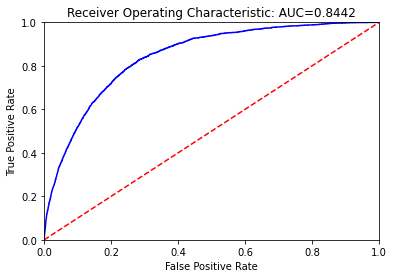

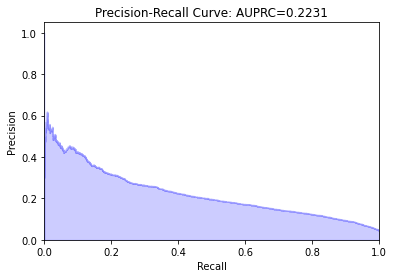

In [26]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(random_state=random_seed)
start = time.time()
logreg.fit(X_train1,y_train)
runtime = time.time()-start
import pickle
with open('task2_logreg.pickle', 'wb') as model_dump:
    pickle.dump(logreg, model_dump)
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test1)
result = PlotROCCurve(probs[:,1], y_test, ci=confidence_interval, random_seed=random_seed)

results = ["LR"]
results.extend(result)
results.append(runtime)
result_list.append(results)

RandomForest:
Training time: 62.639386892318726 seconds
AUC: 0.8407706848404661
AUPRC: 0.2460753746393141
Sensitivity: 0.7682141646899356
Specificity: 0.7614497680187422
Score thresold: 0.06
2.5 97.5


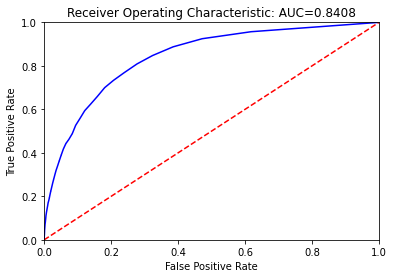

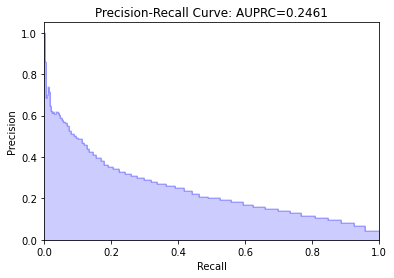

[0.09215098 0.01494237 0.00662228 0.01066576 0.01900362 0.00711
 0.01096082 0.01790809 0.00205715 0.00510706 0.0093599  0.08919297
 0.10160306 0.05910775 0.05379844 0.11359876 0.09391869 0.03628252
 0.04167966 0.00622977 0.00229175 0.00526331 0.0034899  0.00935495
 0.00580939 0.00311606 0.00683886 0.00772209 0.00513278 0.0022343
 0.00502568 0.00510151 0.00717208 0.00588868 0.00756508 0.00440276
 0.00137949 0.0061265  0.00532486 0.0027789  0.00583338 0.00484965
 0.00546775 0.00595187 0.00366704 0.00494851 0.00183737 0.00261576
 0.00733082 0.00308285 0.00252693 0.00489973 0.00152786 0.0035252
 0.00501293 0.00268054 0.00488683 0.00570493 0.00798243 0.00344499
 0.00512192 0.0047704  0.00372162 0.00529012]


In [27]:
print("RandomForest:")
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier(random_state=random_seed)
start = time.time()
rf.fit(X_train1,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test1)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
importances = rf.feature_importances_
print(importances)

results = ["RF"]
results.extend(result)
results.append(runtime)
result_list.append(results)

GradientBoosting:
Training time: 78.42661809921265 seconds
AUC: 0.853592881442572
AUPRC: 0.25992129445217027
Sensitivity: 0.788546255506608
Specificity: 0.7617407016093221
Score thresold: 0.04406093244109639
2.5 97.5


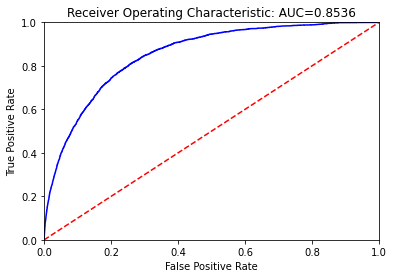

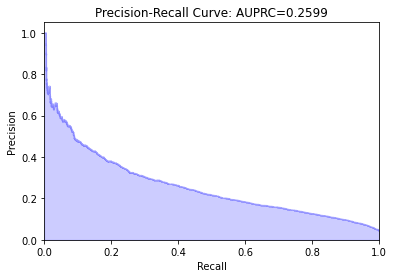

In [28]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=random_seed)
start = time.time()
gb.fit(X_train1, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test1)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["GB"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [29]:
class MLP(tf.keras.Model):
    def __init__(self):
        super(MLP, self).__init__()
        self.dense_1 = Dense(128, activation='relu')
        self.dense_2 = Dense(64, activation='relu')
        self.classifier = Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.classifier(x)

In [30]:
# skip this cell if not retraining
mlp = MLP()
mlp.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy', 'AUC', {'auprc': metrics.AUC(name='auprc', curve='PR')}, 
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
mlp.fit(X_train1.astype(np.float32), y_train, batch_size=200, epochs=100)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')
mlp.save('critical_triage_mlp')

Epoch 1/100
1366/1366 [==============================] - 5s 2ms/step - loss: 0.1442 - accuracy: 0.9571 - auc: 0.8309 - auprc: 0.1970 - true_positives: 351.0000 - true_negatives: 260962.0000 - precision: 0.4323 - recall: 0.0302
Epoch 2/100
1366/1366 [==============================] - 3s 2ms/step - loss: 0.1345 - accuracy: 0.9580 - auc: 0.8597 - auprc: 0.2601 - true_positives: 499.0000 - true_negatives: 261073.0000 - precision: 0.5878 - recall: 0.0430
Epoch 3/100
1366/1366 [==============================] - 3s 2ms/step - loss: 0.1331 - accuracy: 0.9580 - auc: 0.8643 - auprc: 0.2685 - true_positives: 547.0000 - true_negatives: 261031.0000 - precision: 0.5825 - recall: 0.0471
Epoch 4/100
1366/1366 [==============================] - 3s 2ms/step - loss: 0.1318 - accuracy: 0.9584 - auc: 0.8677 - auprc: 0.2803 - true_positives: 675.0000 - true_negatives: 260993.0000 - precision: 0.6109 - recall: 0.0581
Epoch 5/100
1366/1366 [==============================] - 3s 2ms/step - loss: 0.1308 - accura

1366/1366 [==============================] - 3s 2ms/step - loss: 0.0838 - accuracy: 0.9718 - auc: 0.9516 - auprc: 0.6655 - true_positives: 5034.0000 - true_negatives: 260299.0000 - precision: 0.8175 - recall: 0.4336
Epoch 72/100
1366/1366 [==============================] - 3s 2ms/step - loss: 0.0837 - accuracy: 0.9717 - auc: 0.9513 - auprc: 0.6654 - true_positives: 5054.0000 - true_negatives: 260246.0000 - precision: 0.8111 - recall: 0.4354
Epoch 73/100
1366/1366 [==============================] - 3s 2ms/step - loss: 0.0833 - accuracy: 0.9718 - auc: 0.9518 - auprc: 0.6681 - true_positives: 5063.0000 - true_negatives: 260277.0000 - precision: 0.8154 - recall: 0.4361
Epoch 74/100
1366/1366 [==============================] - 3s 2ms/step - loss: 0.0827 - accuracy: 0.9721 - auc: 0.9524 - auprc: 0.6730 - true_positives: 5114.0000 - true_negatives: 260302.0000 - precision: 0.8202 - recall: 0.4405
Epoch 75/100
1366/1366 [==============================] - 3s 2ms/step - loss: 0.0830 - accuracy: 

MLP:
2134/2134 [==============================] - 2s 817us/step
AUC: 0.7328858090923656
AUPRC: 0.14368191190058993
Sensitivity: 0.6665537106065741
Specificity: 0.6913807095717152
Score thresold: 0.0053608525
2.5 97.5


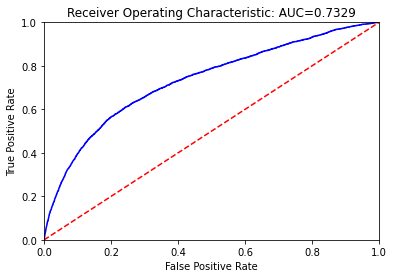

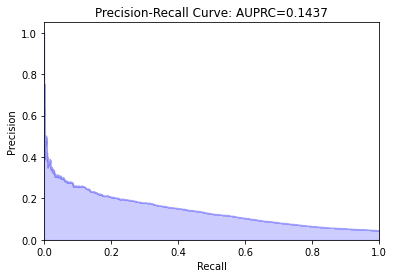

In [32]:
print("MLP:")
mlp = load_model('critical_triage_mlp')
probs = mlp.predict(X_test1.astype(np.float32))
result = PlotROCCurve(probs,y_test, ci=confidence_interval, random_seed=random_seed)
results = ["MLP"]
results.extend(result)
results.append(runtime)
result_list.append(results)